We place a vertical insulating wall across the unit square positioned at the centre with holes of size $\epsilon$ spaced a distance $\delta$ apart. There are now many new boundary conditions to consider:

1.  Corners where the wall meets the bottom or top of the square.
2.  The two straight edges of the wall.
3.  Corners of the wall created by the hole sections.

We assume that sharp right angles are smoothed off so that the normal is diagonal to the grid there.



In [2]:
import numpy as np
import matplotlib.pyplot as plt

def create_wall_mask(N, epsilon, delta):
    '''
    Creates a boolean mask for the insulating wall with holes.
    Args:
        N: The number of grid points in each direction.
        epsilon: The size of the holes.
        delta: The spacing between holes.
    Returns:
        A boolean array where True indicates an insulator.
    '''
    is_insulator = np.full((N + 1, N + 1), False)

    # Place the wall as a solid line in the middle column
    wall_j = N // 2
    is_insulator[:, wall_j] = True

    # Convert real-world dimensions to grid units
    hole_size_grid = int(epsilon * N)
    block_size_grid = int((epsilon + delta) * N)

    if hole_size_grid <= 0:
        return is_insulator # Return a solid wall if hole size is invalid

    # Start from the center of the grid and work outwards
    center_i = N // 2

    # Place central hole
    start_i = center_i - hole_size_grid // 2
    end_i = start_i + hole_size_grid
    # Check if the whole hole fits
    if start_i >= 0 and end_i <= N:
        is_insulator[start_i:end_i, wall_j] = False

    # Place holes symmetrically above and below the center
    k = 1
    while True:
        holes_were_placed_this_iteration = False

        # Attempt to place hole above center
        hole_center_up = center_i + k * block_size_grid
        start_i_up = hole_center_up - hole_size_grid // 2
        end_i_up = start_i_up + hole_size_grid

        # Check if the entire hole fits within the bounds [0, N]
        if start_i_up >= 0 and end_i_up <= N:
            is_insulator[start_i_up:end_i_up, wall_j] = False
            holes_were_placed_this_iteration = True

        # Attempt to place hole below center
        hole_center_down = center_i - k * block_size_grid
        start_i_down = hole_center_down - hole_size_grid // 2
        end_i_down = start_i_down + hole_size_grid

        # Check if the entire hole fits within the bounds [0, N]
        if start_i_down >= 0 and end_i_down <= N:
            is_insulator[start_i_down:end_i_down, wall_j] = False
            holes_were_placed_this_iteration = True

        # If we could not place any new holes, then we are done
        if not holes_were_placed_this_iteration:
            break

        k += 1

    return is_insulator


def solve_laplace_with_wall(N=80, sigma=1.9, tol=1e-6, max_iter=20000, epsilon=0.1, delta=0.15):
    '''
    Solves Laplace's equation for a unit square with an internal insulating wall.
    '''
    # Initialisation
    T = np.full((N + 1, N + 1), 0.5)
    is_insulator = create_wall_mask(N, epsilon, delta)

    # Apply Fixed Boundary Conditions
    T[:, 0] = 0.0  # Left side
    T[:, N] = 1.0  # Right side

    # Iteration Loop

    for iteration in range(max_iter):
        T_old = T.copy()

        # Update all non-fixed points using Gauss-Seidel
        for i in range(N + 1):
            for j in range(1, N):

                # Skip points that are part of the insulator wall
                if is_insulator[i, j]:
                    continue

                # Determine neighbor values using ghost point logic for boundaries

                # Top neighbor (Neumann boundary at y=1)
                term_U = T[i - 1, j] if i == N else T[i + 1, j]

                # Bottom neighbor (Neumann boundary at y=0)
                term_D = T[i + 1, j] if i == 0 else T[i - 1, j]

                # Right neighbor (check for insulator)
                term_R = T[i, j - 1] if is_insulator[i, j + 1] else T[i, j + 1]

                # Left neighbor (check for insulator)
                term_L = T[i, j + 1] if is_insulator[i, j - 1] else T[i, j - 1]

                # Apply the successive over-relaxation formula
                T[i, j] = (1 - sigma) * T_old[i, j] + (sigma / 4.0) * (term_U + term_D + term_R + term_L)

        # Check for Convergence
        max_change = np.abs(T - T_old).max()

        if max_change < tol:
            break
    else:
        print(f"Maximum number of iterations ({max_iter}) reached.")

    return T, is_insulator, iteration + 1


def plot_contours_with_wall(T, N, is_insulator):
    '''
    Plots the temperature contours and overlays the wall.
    '''
    x = np.linspace(0, 1, N + 1)
    y = np.linspace(0, 1, N + 1)
    X, Y = np.meshgrid(x, y)

    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, T, levels=30, cmap='inferno')
    plt.colorbar(cp, label='Temperature (T)')
    plt.contour(X, Y, T, levels=cp.levels, cmap='inferno')
    plt.contour(X, Y, is_insulator, levels=[0.5], colors='black', linewidths=2)

    plt.title("Steady-State Temperature with Insulating Wall")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def plot_cross_sections(T, N, wall_mask):
    '''
    Plots horizontal cross-sections of the temperature distribution.
    '''
    x_vals = np.linspace(0, 1, N + 1)
    center_i = N // 2
    wall_j = N // 2

    # Find a y0 that goes through the center of a hole
    y0_hole_index = center_i

    # Find a y0 that goes through the center of an insulator
    # Start at the center and move up until we find an insulator point
    y0_insulator_index = -1
    for i in range(center_i, N):
        if wall_mask[i, wall_j]:
            y0_insulator_index = i + 2 # Move to the middle of the insulator
            break

    plt.figure(figsize=(8, 5))

    # Plot cross-section through a hole
    plt.plot(x_vals, T[y0_hole_index, :], label=f'Cross-section through hole (y ≈ {y0_hole_index/N:.2f})')

    # Plot cross-section through an insulator
    if y0_insulator_index != -1:
        plt.plot(x_vals, T[y0_insulator_index, :], label=f'Cross-section through insulator (y ≈ {y0_insulator_index/N:.2f})')

    # Plot cross-section with no wall for comparison (from the first problem)
    T_nowall = np.outer(np.ones(N+1), x_vals) # Analytic solution T(x,y) = x
    plt.plot(x_vals, T_nowall[center_i, :], '--', color='gray', label='No Wall (Reference)')

    plt.title("Temperature along Horizontal Cross-Sections")
    plt.xlabel("x")
    plt.ylabel("Temperature (T)")
    plt.grid(True)
    plt.legend()
    plt.show()

def calculate_insulator_quality(T, N, kappa=1.0):
    '''
    Calculates the total heat flux Q across the x=1 boundary.
    '''
    delta_x = 1.0 / N
    # Gradient at the right boundary (x=1) using a backward difference
    # (T[i, N] - T[i, N-1]) / delta_x
    dT_dx = (T[:, N] - T[:, N-1]) / delta_x
    # Total heat flux Q is the integral of -kappa * dT/dx along the y-axis
    # Integral becomes a sum, and dy becomes delta_y (which is also delta_x)
    Q = -kappa * np.sum(dT_dx) * delta_x
    return Q

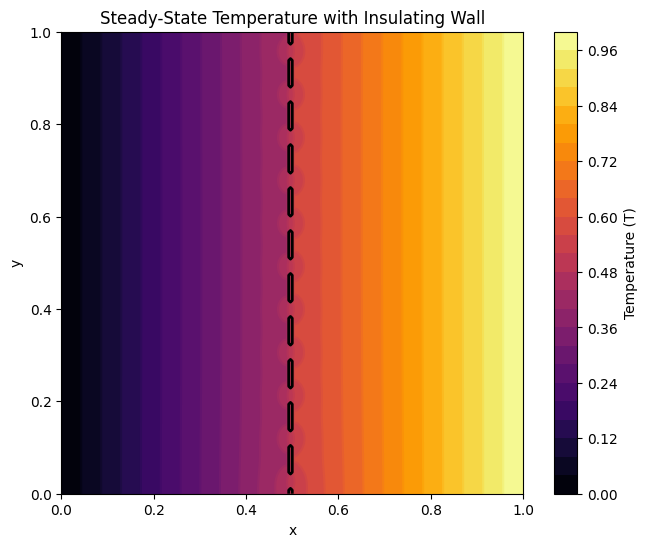

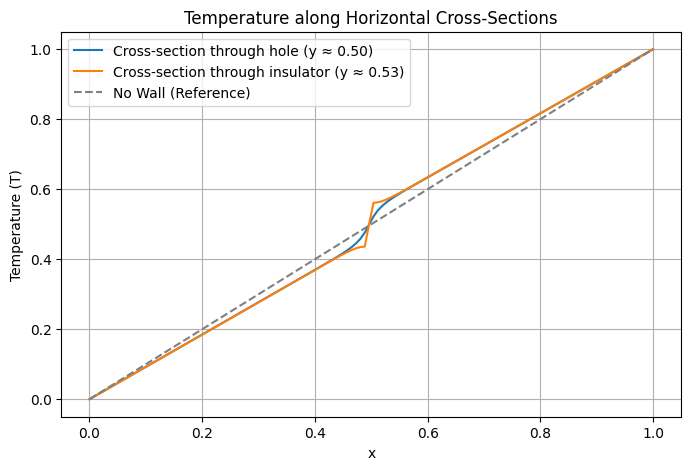

Calculated Total Heat Flux (Q) with wall: -0.9246
Reference Total Heat Flux (Q) with no wall: -1.0078


In [3]:
GRID_POINTS = 129
SIGMA = 1.9
TOLERANCE = 1e-5

# Wall parameters (epsilon for hole size, delta for spacing)
EPSILON = 4.0 / GRID_POINTS
DELTA = 8.0 / GRID_POINTS

temperature_grid, wall_mask, iterations = solve_laplace_with_wall(
    N=GRID_POINTS,
    sigma=SIGMA,
    tol=TOLERANCE,
    epsilon=EPSILON,
    delta=DELTA
)

plot_contours_with_wall(temperature_grid, GRID_POINTS, wall_mask)
plot_cross_sections(temperature_grid, GRID_POINTS, wall_mask)
Q_value = calculate_insulator_quality(temperature_grid, GRID_POINTS)
Q_no_wall = calculate_insulator_quality(np.outer(np.ones(GRID_POINTS+1), np.linspace(0,1,GRID_POINTS+1)), GRID_POINTS)

print(f"Calculated Total Heat Flux (Q) with wall: {Q_value:.4f}")
print(f"Reference Total Heat Flux (Q) with no wall: {Q_no_wall:.4f}")

We use a generalised "ghost point" method that handles all boundary points without needing a separate formula for each case. The method is based on the Neumann boundary condition for an insulator, which states that the temperature gradient normal to the boundary is zero. Consider updating a generic point $T_{i, j}$. When a neighbor is an insulator, its value is replaced by the value of the point on the opposite side.

A odd numbered grid size results in an even number of grid points in each direction and an odd number of intervals between such grid points. This allows a single symmetrically centred column of grid points for the insultating wall.

Putting holes in the wall allows heat to flow from the hot side to the cold side. The insulating sections block this flow, forcing the heat to funnel through the open holes. When there is no wall, the temperature increases linearly from $0$ to $1$. Through a hole, the temperature profile is smooth and nearly linear, with a higher gradient close to the hole. Through an insulated section, we see a sharp non-smooth cross-section at the wall, caused by perfect insulation.

The total heat flux across the boundary $x = 1$ is a gauge of the quality of the insulating layer. At any point $(x, y)$, the heat flux is given by $-\kappa\nabla T(x, y)$. Thus, the total heat flux $Q$ across the boundary at $x=1$ is the integral of the $x$-component of this vector along the line from $y=0$ to $y=1$ evaluated at $x=1$,
\begin{equation}
    Q = \int_0^1 -\kappa \frac{\partial T}{\partial x}\,dy.
\end{equation}
This serves as a measure ofthe insulator's quality - a lower magnitude of $Q$ means less heat is flowing out of the hot boundary, implying the wall is a better insulator. Discretising, this becomes the sum
\begin{equation}
    Q = -\kappa\sum_{i=0}^N \frac{T_{i,N} - T_{i,N-1}}{\Delta x}\Delta y = -\kappa\sum_{i=0}^N (T_{i, N} - T_{i, N-1}).
\end{equation}
A lower $\kappa$ results in a lower magnitude of $Q$ and a perfect insulator would result in $Q=0$.


Starting investigation for alpha = 4.0, k = 1.0
Starting investigation for alpha = 1.0, k = 1.0
Starting investigation for alpha = 0.25, k = 1.0


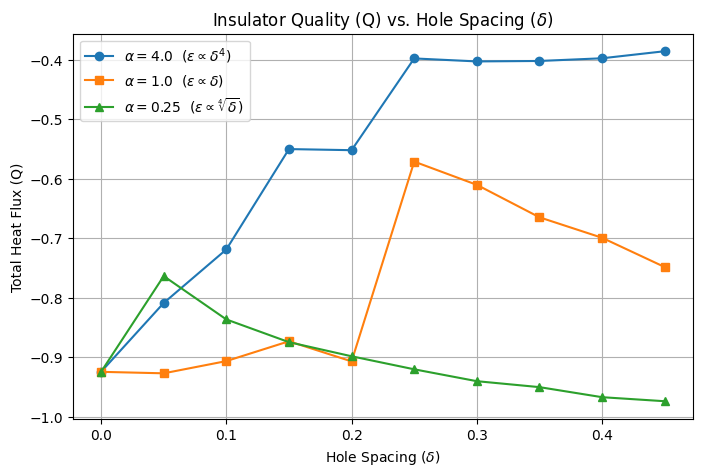

In [36]:
def run_investigation(alpha, k, N, delta_range):
    '''
    Runs a series of simulations for a given alpha and k.

    Returns:
        tuple: (list of delta values, list of Q values)
    '''
    print(f"Starting investigation for alpha = {alpha}, k = {k}")
    q_values = []

    for delta_real in delta_range:
        # Calculate epsilon based on the power law
        epsilon_real = k * (delta_real ** alpha)

        # Discretise: find the nearest integer multiple of Delta
        delta_grid = max(1, int(delta_real * N + 0.5))
        epsilon_grid = max(1, int(epsilon_real * N + 0.5))

        # Convert back to real values for the solver
        delta_sim = delta_grid / N
        epsilon_sim = epsilon_grid / N

        # Run the simulation (using a lower tolerance for speed)
        T, _, _ = solve_laplace_with_wall(
            N=N,
            sigma=1.85, # Slightly lower sigma can be more stable for varied geometries
            tol=1e-5,
            max_iter=2000,
            epsilon=epsilon_sim,
            delta=delta_sim
        )

        # Calculate insulator quality Q
        q = calculate_insulator_quality(T, N)
        q_values.append(q)

    return q_values

N_VAL = 51

delta_values = np.array([0.05 * i for i in range(10)])
# Case 1: alpha = 2.0 (Holes close up quickly)
q_alpha_2_0 = run_investigation(alpha=4.0, k=1.0, N=N_VAL, delta_range=delta_values)
# Case 2: alpha = 1.0 (Linear scaling)
q_alpha_1_0 = run_investigation(alpha=1.0, k=1.0, N=N_VAL, delta_range=delta_values)
# Case 3: alpha = 0.5 (Holes close up slowly)
q_alpha_0_5 = run_investigation(alpha=0.25, k=1.0, N=N_VAL, delta_range=delta_values)

plt.figure(figsize=(8, 5))
plt.plot(delta_values, q_alpha_2_0, 'o-', label=r'$\alpha = 4.0$  ($\epsilon \propto \delta^4$)')
plt.plot(delta_values, q_alpha_1_0, 's-', label=r'$\alpha = 1.0$  ($\epsilon \propto \delta$)')
plt.plot(delta_values, q_alpha_0_5, '^-', label=r'$\alpha = 0.25$  ($\epsilon \propto \sqrt[4]{\delta}$)')

plt.title('Insulator Quality (Q) vs. Hole Spacing ($\\delta$)')
plt.xlabel('Hole Spacing ($\\delta$)')
plt.ylabel('Total Heat Flux (Q)')
plt.legend()
plt.grid(True)
plt.show()


The equation $\epsilon = k\delta^\alpha$, represents a design constraint for the perforated wall. It dictates how the size of the holes $\epsilon$ must change as the spacing between them $\delta$ is varied. The exponent $\alpha$ is the parameter that controls the nature of this relationship.

*   $\alpha = 4.0$: As the spacing $\delta$ increases, the total heat flux $Q$ broadly decreases (in magnitude) to a constant value since $\epsilon$ scales as $\delta^4$. As the spacing increases, the holes close up very quickly, creating a near solid wall.
*   $\alpha = 0.25$: This case behaves in the opposite way. As $\delta$ increases, the heat flux $Q$ increases (in magnitude), approaching $1$ the value for no wall. This is because as the spacing increases, the hole size grows and the wall effectively vanishes.